In [1]:
# Install the Kaggle library
! pip install kaggle

In [4]:
# Make a directory named “.kaggle”
! mkdir ~/.kaggle

In [8]:
# Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle competitions download web-traffic-time-series-forecasting

 99% 101M/102M [00:00<00:00, 107MB/s] 
100% 102M/102M [00:00<00:00, 111MB/s]
 94% 64.0M/68.2M [00:00<00:00, 77.9MB/s]
100% 68.2M/68.2M [00:00<00:00, 77.9MB/s]
 95% 96.0M/101M [00:01<00:00, 95.4MB/s]
100% 101M/101M [00:01<00:00, 97.0MB/s] 
 89% 59.0M/66.0M [00:00<00:00, 78.5MB/s]
100% 66.0M/66.0M [00:00<00:00, 102MB/s] 
 93% 139M/150M [00:01<00:00, 107MB/s] 
100% 150M/150M [00:01<00:00, 91.6MB/s]
 98% 94.0M/96.0M [00:01<00:00, 60.4MB/s]
100% 96.0M/96.0M [00:01<00:00, 66.2MB/s]


In [11]:
! unzip train_1.csv.zip

Archive:  train_1.csv.zip
  inflating: train_1.csv             


In [12]:
! unzip train_2.csv.zip

Archive:  train_2.csv.zip
  inflating: train_2.csv             


In [13]:
import numpy as np 
import pandas as pd 
from fbprophet import Prophet
import matplotlib.pyplot as plt
import math as math
import random
%matplotlib inline

In [14]:
wiki = pd.read_csv("train_1.csv")
wiki_test = pd.read_csv("train_2.csv")
wiki.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [15]:
wiki.shape

(145063, 551)

In [16]:
print("Number of records with NaN value: ", wiki[wiki.isnull().any(axis=1)].shape[0], "\n")

Number of records with NaN value:  27786 



In [17]:
# assumption that missing data is due to no views on that day
siki = wiki.fillna(0)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 22823 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 39791 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 38307 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 33609 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 34905 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 36947 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 21335 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotli

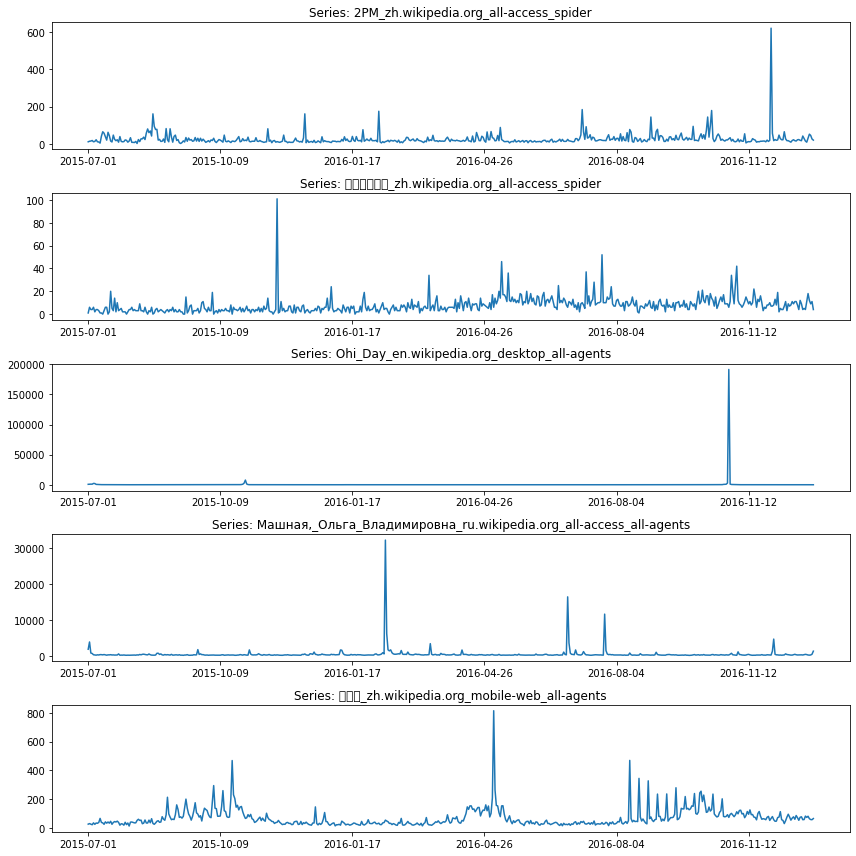

In [18]:
def plot_ts(df, row_num, start_col = 1, ax=None):
    if ax is None:
            fig = plt.figure(figsize=(10, 6))
            ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
        
    series_title = df.iloc[row_num, 0]
    sample_series = df.iloc[row_num, start_col:]
    sample_series.plot(ax=ax)
    ax.set_title("Series: %s" % series_title)

fig, axs = plt.subplots(5,1,figsize=(12,12))
plot_ts(wiki, 1, ax=axs[0])
plot_ts(wiki, 1000, ax=axs[1])
plot_ts(wiki, 10000, ax=axs[2])
plot_ts(wiki, 100000, ax=axs[3])
plot_ts(wiki, 106263, ax=axs[4])

plt.tight_layout()

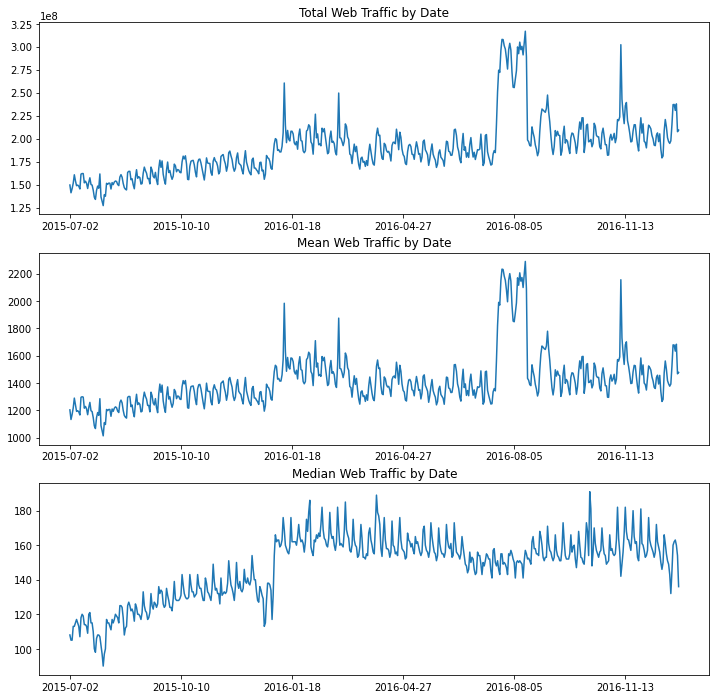

In [106]:
#calculate sum/mean/median of each date
wiki_tf = wiki.drop(columns=['Page'])
train_sum = wiki_tf.sum(axis=0)
train_mean = wiki_tf.mean(axis=0)
train_median = wiki_tf.median(axis=0)

#plot sum/mean/median of web traffic
fig, axs = plt.subplots(3,1,figsize=(12,12))
train_sum[1:,].plot(title='Total Web Traffic by Date', ax=axs[0])
train_mean[1:,].plot(title='Mean Web Traffic by Date', ax=axs[1])
train_median[1:,].plot(title='Median Web Traffic by Date', ax=axs[2])

In [78]:
#calculate sum/mean/median of each date
wiki_tf = wiki_test.drop(columns=['Page'])
test_sum = wiki_tf.sum(axis=0)
test_mean = wiki_tf.mean(axis=0)
test_median = wiki_tf.median(axis=0)

test_median = pd.DataFrame(test_median).reset_index()
test_median.columns = ["ds", "y"]
test_median.ds = pd.to_datetime(test_median.ds)

test_mean = pd.DataFrame(test_mean).reset_index()
test_mean.columns = ["ds", "y"]
test_mean.ds = pd.to_datetime(test_mean.ds)

test_sum = pd.DataFrame(test_sum).reset_index()
test_sum.columns = ["ds", "y"]
test_sum.ds = pd.to_datetime(test_sum.ds)

In [56]:
# function to initialize prophet model and train it
def trainProphetModel(train_data):
  m = Prophet(interval_width = 0.95,
              daily_seasonality=True,
              yearly_seasonality = True,
              weekly_seasonality = True,
              changepoint_prior_scale = 2)
  m.add_country_holidays(country_name='US')
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  m.fit(train_data)
  return m

In [63]:
# function to predict the views for future period
def predictFuture(model, periods=248):
  future = model.make_future_dataframe(periods=periods)
  forecast = model.predict(future)
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  return model, forecast

In [48]:
# plot the outputs
def visualize(model, forecast):
  model.plot(forecast)
  model.plot_components(forecast)

In [80]:
# plot the actual vs predicted
def actualVsPredicted(forecast, test):
  predictions = pd.DataFrame(forecast)
  f, ax = plt.subplots(figsize=(14,5))
  f.set_figheight(5)
  f.set_figwidth(15)
  test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
  predictions.plot(kind='line', x='ds', y='yhat', color='green', label='Forecast', ax=ax)
  plt.title('Forecast vs Actuals')
  plt.show()

## Predicting the page median values 

In [53]:
train_med = pd.DataFrame(train_median).reset_index()
train_med.columns = ["ds", "y"]
train_med[:5]

,ds,y
0,2015-07-01,109.0
1,2015-07-02,108.0
2,2015-07-03,105.0
3,2015-07-04,105.0
4,2015-07-05,113.0


In [86]:
median_model = trainProphetModel(train_med)
median_model, median_forecast = predictFuture(median_model, periods=50)

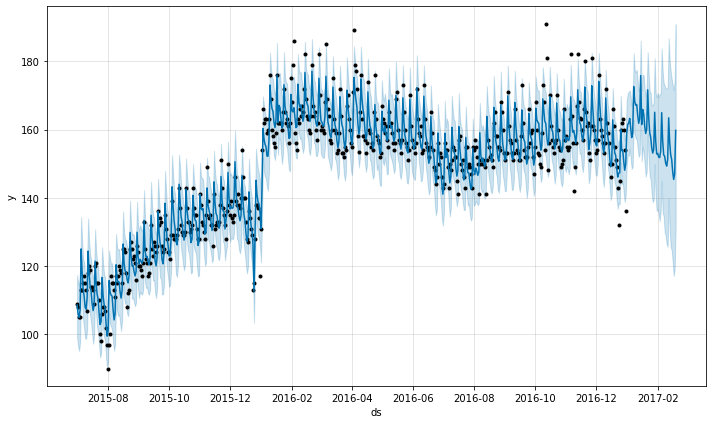

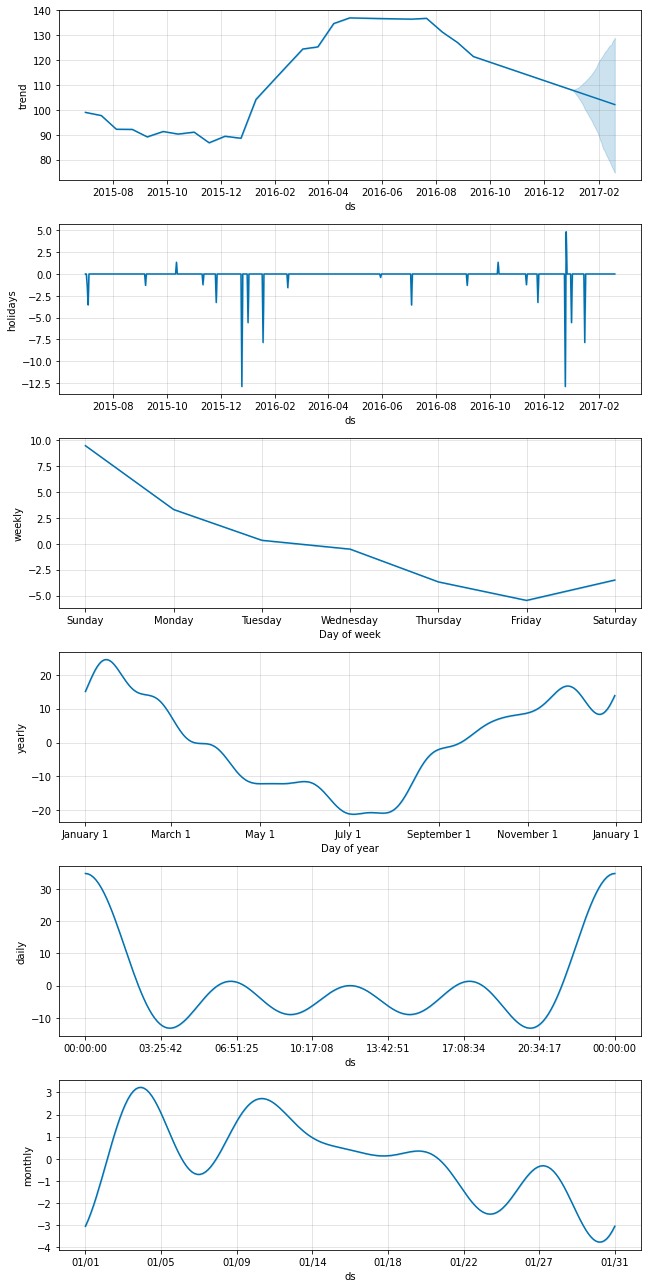

In [87]:
visualize(median_model, median_forecast)

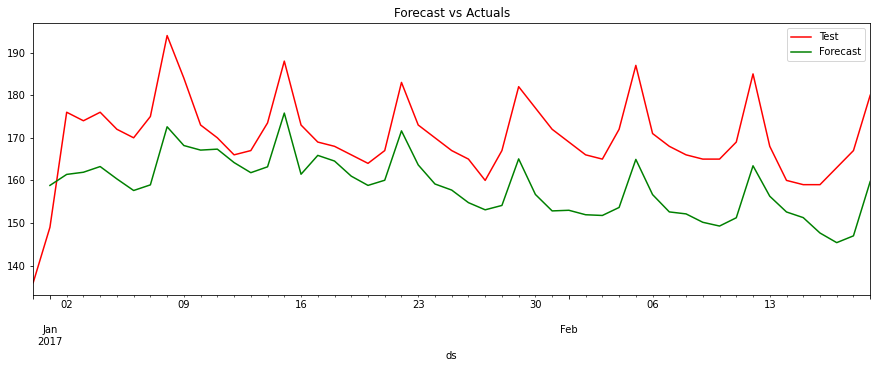

In [93]:
# prediction for next 50 days
actualVsPredicted(median_forecast[-50:], test_median[549:600])

## Prediction of total values

In [132]:
train_sum = pd.DataFrame(train_sum).reset_index()
train_sum.columns = ["ds", "y"]
train_sum[:5]

,ds,y
0,2015-07-01,148672476.0
1,2015-07-02,149593840.0
2,2015-07-03,141164198.0
3,2015-07-04,145612937.0
4,2015-07-05,151495372.0


In [133]:
sum_model = trainProphetModel(train_sum)
sum_model, sum_forecast = predictFuture(sum_model, periods=50)

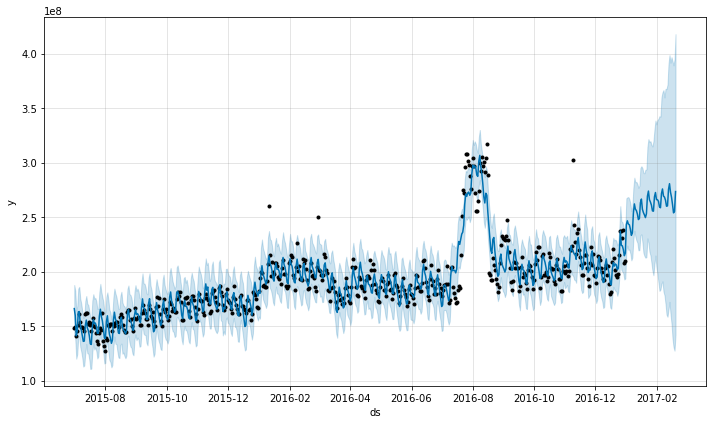

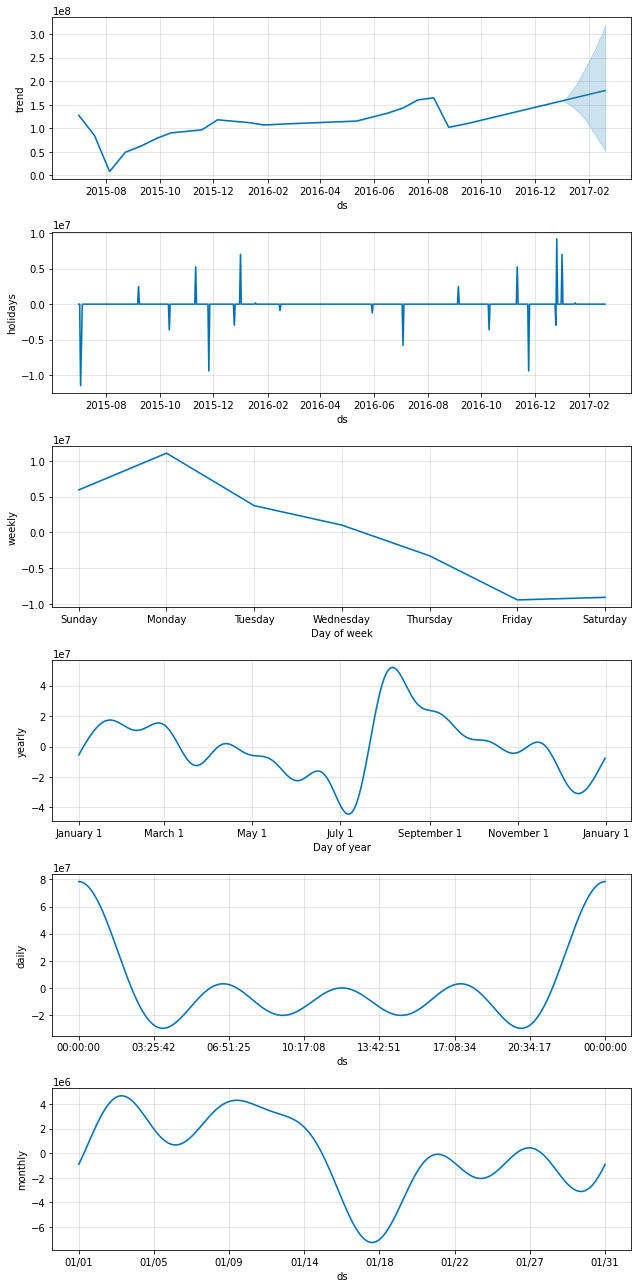

In [134]:
visualize(sum_model, sum_forecast)

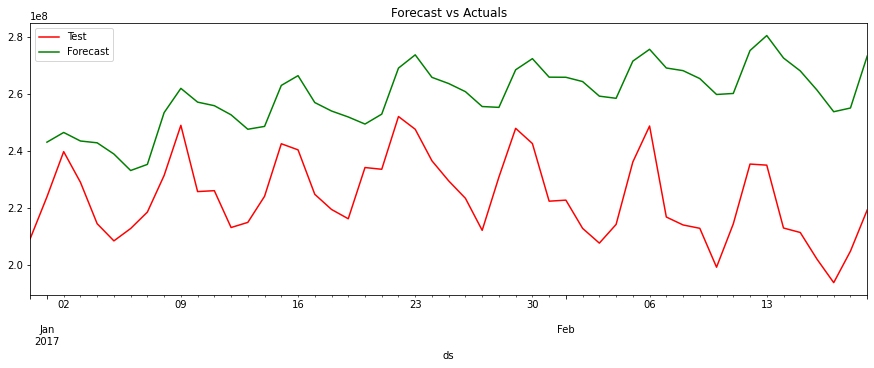

In [135]:
actualVsPredicted(sum_forecast[-50:], test_sum[549:600])

## Prediction of mean values

In [107]:
train_mean = pd.DataFrame(train_mean).reset_index()
train_mean.columns = ["ds", "y"]
train_mean[:5]

,ds,y
0,2015-07-01,1195.856567
1,2015-07-02,1204.003638
2,2015-07-03,1133.675969
3,2015-07-04,1170.437324
4,2015-07-05,1217.769300


In [111]:
mean_model = trainProphetModel(train_mean)
mean_model, mean_forecast = predictFuture(mean_model, periods=50)

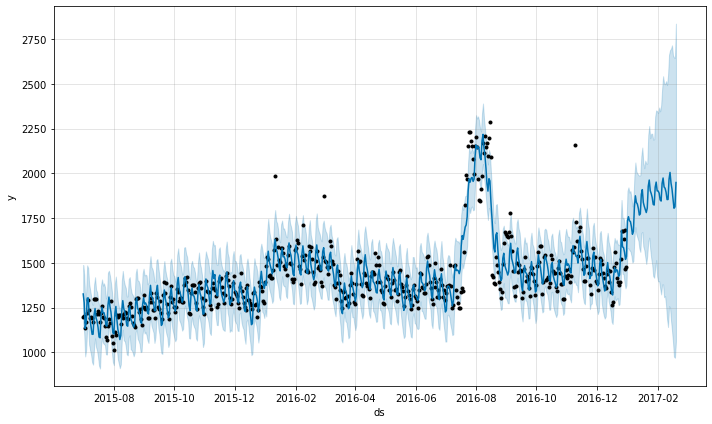

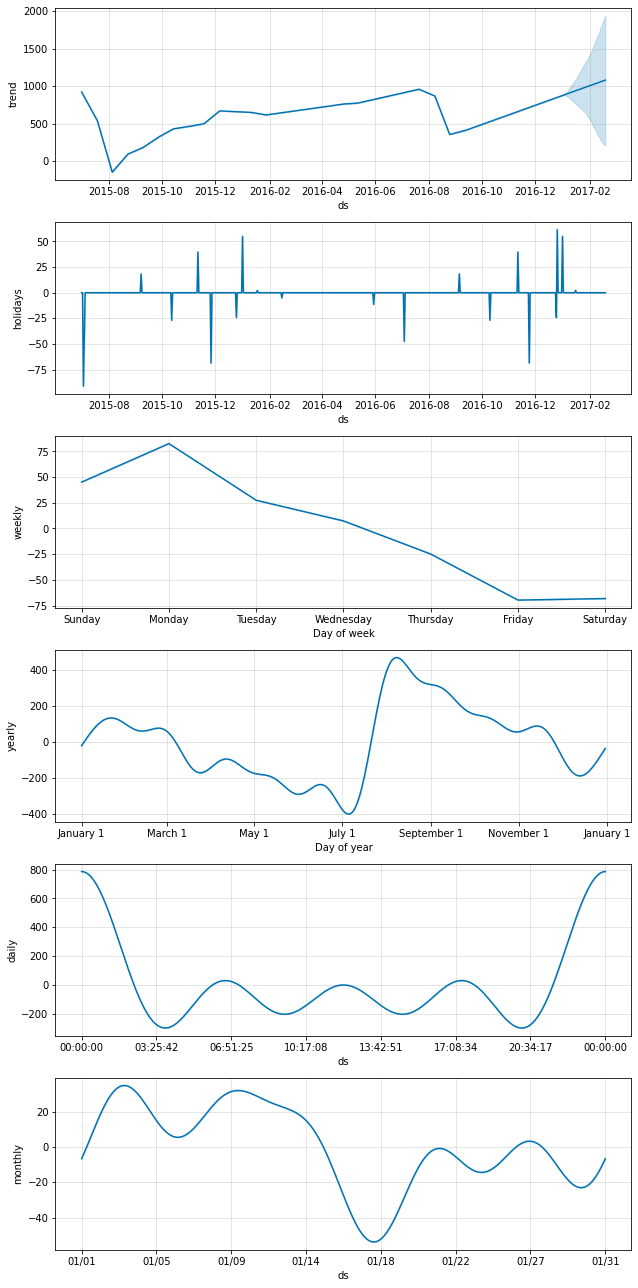

In [112]:
visualize(mean_model, mean_forecast)

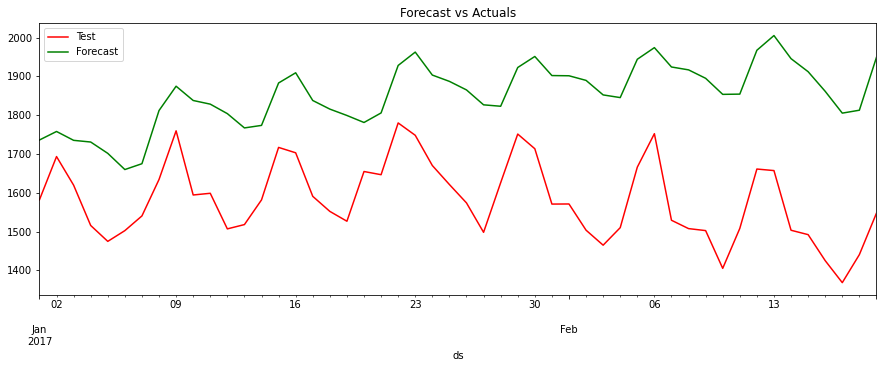

In [113]:
actualVsPredicted(mean_forecast[-50:], test_mean[550:600])

## calculate errors

In order to measure the performance of the model more accurately, calculating mean absolute percentage error(MAPE) and mean absolute error

In [137]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [151]:
print('The errors for Median time series is: ')
mape = mean_absolute_percentage_error(test_median['y'][:600],median_forecast['yhat'])
print("MAPE",round(mape,4))
print("MAE yhat\t: {}\nMAE trend\t: {}\nMAE yhat_lower: {}\nMAE yhat_upper: {}".format(
    mean_absolute_error(test_median['y'][:600].values, median_forecast['yhat']),
    mean_absolute_error(test_median['y'][:600].values, median_forecast['trend']),
    mean_absolute_error(test_median['y'][:600].values, median_forecast['yhat_lower']),
    mean_absolute_error(test_median['y'][:600].values, median_forecast['yhat_upper'])))

The errors for Median time series is: 
MAPE 2.7531
MAE yhat	: 4.146148786572965
MAE trend	: 37.24553748494217
MAE yhat_lower: 11.04300580286423
MAE yhat_upper: 9.199655872392363


In [142]:
print('The errors for summation time series is: ')
mape = mean_absolute_percentage_error(test_sum['y'][:600],sum_forecast['yhat'])
print("MAPE",round(mape,4))
print("MAE yhat\t: {}\nMAE trend\t: {}\nMAE yhat_lower: {}\nMAE yhat_upper: {}".format(
    mean_absolute_error(test_sum['y'][:600].values, sum_forecast['yhat']),
    mean_absolute_error(test_sum['y'][:600].values, sum_forecast['trend']),
    mean_absolute_error(test_sum['y'][:600].values, sum_forecast['yhat_lower']),
    mean_absolute_error(test_sum['y'][:600].values, sum_forecast['yhat_upper'])))

The errors for summation time series is: 
MAPE 4.864
MAE yhat	: 9923625.922423273
MAE trend	: 77126798.98233755
MAE yhat_lower: 23411977.605107065
MAE yhat_upper: 29987806.60030269


In [140]:
print('The errors for mean time series is: ')
mape = mean_absolute_percentage_error(test_mean['y'][:600],mean_forecast['yhat'])
print("MAPE",round(mape,4))
print("MAE yhat\t: {}\nMAE trend\t: {}\nMAE yhat_lower: {}\nMAE yhat_upper: {}".format(
    mean_absolute_error(test_mean['y'][:600].values, mean_forecast['yhat']),
    mean_absolute_error(test_mean['y'][:600].values, mean_forecast['trend']),
    mean_absolute_error(test_mean['y'][:600].values, mean_forecast['yhat_lower']),
    mean_absolute_error(test_mean['y'][:600].values, mean_forecast['yhat_upper'])))

The errors for mean time series is: 
MAPE 4.9224
MAE yhat	: 73.61144497982485
MAE trend	: 798.0340271357501
MAE yhat_lower: 167.20818409935902
MAE yhat_upper: 213.17672853220395


## Hyperparameter tuning

Here are some other hyperparameters that can be tuned in Prophet model in addition to holidays(US holiday has been added to the model):

holiday_prior_scale: determines the flexibility of the holiday effects. It defaults to 10.0.

n_changepoints: the number of automatically placed changepoints, used to capture the changes in trend. The default value is 25.

changepoint_prior_scale: determines the flexibility of the trend, and in particular how much the trend changes at changepoints. The default value is 0.05. If it is too small, the trend will be underfit and if it is too large, the trend will be overfit.

seasonality_mode: ‘additive’ or ‘multiplicative’. Default value is ‘additive’. This parameter indicates the relationship between the magnitude of seasonal fluctuations and the magnitude of the time series.

fourier_order: how quickly the seasonality can change. It defaults to 10. The parameter can be increased to fit higher-frequency changes in seasonality, which usually leads a less smooth fit.

In [143]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.01,0.05,0.1],
              'holidays_prior_scale':[1,2,5],
              'n_changepoints' : [2,10,15],
              'fourier_order': [4,6,8,12]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


In [145]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
  test = pd.DataFrame()
  print(p)
  random.seed(17)
  train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                        holidays_prior_scale = p['holidays_prior_scale'],
                        n_changepoints = p['n_changepoints'],
                        seasonality_mode = p['seasonality_mode'],
                        weekly_seasonality=True,
                        yearly_seasonality = True, 
                        interval_width=0.95)
  train_model.add_country_holidays(country_name='US')
  train_model.add_seasonality(name='monthly', period=30.5, fourier_order=p['fourier_order'])

  train_model.fit(train_med)
  # not including history
  train_forecast = train_model.make_future_dataframe(periods=50,include_history = False)
  train_forecast = train_model.predict(train_forecast)
  test = train_forecast[['ds','yhat']]
  MAPE = mean_absolute_percentage_error(test_med['y'][550:600],abs(test['yhat']))
  print('Mean Absolute Percentage Error(MAPE)---------------------',MAPE)
  model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.0036964745018
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.148683658650003
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.573200762771691
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.2392863759159045
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.33981992228927
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.887014439891946
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.006081706777453
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.1487835555174195
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.508242627040781
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.268734393471188
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.089270582875537
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.852741880837569
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.006640531310886
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.143102284337183
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.480790901511806
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.2098426857577556
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.179509461563722
{'changepoint_prior_scale': 0.01, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.131490967160091
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.9039776377600885
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.091883737029983
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.103331330637376
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.398880608907075
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.181833997151367
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.9598577614076715
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.904917751219146
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.0920558509368705
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.56860243923981
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.366139209150853
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.366616501379022
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.909865499423389
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.906696626268422
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.090146787489799
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.114644681670525
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.390398740609011
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.333488481895571
{'changepoint_prior_scale': 0.01, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.915920627638554
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.895658071317195
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.092360996763057
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.42419776088923
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.375993145433396
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.076338867777027
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.089448586012118
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.88511284500933
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.084061313317864
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.391746610831158
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.320895827115315
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.256372426331053
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.847558941288414
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.848853590704312
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.087576017281476
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.20545591488561
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.115546691902484
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.119929560518973
{'changepoint_prior_scale': 0.01, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.825179196976891
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.895836910482916
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.086737318744904
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.507817902384366
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.198244632501656
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.332595491321918
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.980535258171719
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.8805416112465485
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.0777960366233375
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.531007512621395
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.182952364554779
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.01045346295397
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.200091800947829
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.894650317503225
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.095387266094893
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 8.542033796621137
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.182800305528289
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.900449832252914
{'changepoint_prior_scale': 0.01, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.092415473376196
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.602240967304638
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.025849531898547
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.216063483586449
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.746360056106521
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.233272688608837
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.766932352454444
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.58283667542427
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.0310427546282295
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.3077156456472325
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.784574114086757
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.114720471339889
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.708997736321775
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.5995309390285
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.0306872475891975
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.132556807062307
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.7584309505114275
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.243491726855387
{'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.777987271866754
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.561279459951014
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.018142296267859
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.087624613346353
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.713693969355148
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.099737475524933
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.76563589899141
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.586971592413554
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.005746502666835
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.0208563505050305
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.751070983955186
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.083709251289433
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.741950021739045
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.586121970458457
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.017373177202959
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.968822277151605
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.692223661548079
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.106641885992722
{'changepoint_prior_scale': 0.05, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.768608735675072
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.583587396692184
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.016445300910143
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.057232840642544
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.775020850209763
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.276680576944456
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.733266681711632
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.488558670424027
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.041369048601709
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.085977463320475
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.720482244725051
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.259814304290685
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.754384910967188
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.581895663548338
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.010211410986236
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.011077859429979
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.751841141900957
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.108575007973009
{'changepoint_prior_scale': 0.05, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.724959510776645
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.573385284946029
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.011882610158038
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.169544915850125
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.724456181638363
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.28863684065767
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.765032042414122
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.585172099688154
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.01193764161232
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.163332480220347
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.741109054885781
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.244686997262768
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.732739955288449
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.576747502800552
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.011900738009108
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.181854254036722
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.727450414416534
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.24384649773423
{'changepoint_prior_scale': 0.05, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.692199039400819
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.4442198649596065
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.893990620455525
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.174170406931695
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.571356891544224
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.4718105924853315
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.593711902552228
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.443096146615594
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.893961447487639
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.012881539536203
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.551776672727751
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.395725698104997
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.642199138509131
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.443201343634966
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.893902703712172
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.954257396961647
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.565604059989253
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.432897039045527
{'changepoint_prior_scale': 0.1, 'fourier_order': 4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.602197672521865
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.423438958635987
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.885281520523295
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.774850484356562
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.4968860760319345
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.429163458635923
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.577588621907581
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.428392613280982
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.875391956930276
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.9798607372660335
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.523976369808471
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.442723272010446
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.589416954930998
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.425256093534109
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.885022952191899
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.949651329014442
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.499935809821705
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.447562944008859
{'changepoint_prior_scale': 0.1, 'fourier_order': 6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.55300608204459
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.431880283077483
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.88468787100959
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.0393881070302795
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.532316132549962
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.545510408420339
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.567373415473108
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.429134028983226
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.884619782124959
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.823134169202609
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.456808042855042
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.437747789072079
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.597514186514054
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.4261356131113185
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.8845952624501425
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.801295918723102
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.440625956095494
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.452941166248506
{'changepoint_prior_scale': 0.1, 'fourier_order': 8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.560633599769693
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.424934146883126
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.8809656122612335
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.051009347097232
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.522755300455577
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.55172914260121
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.607554996266608
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.424622908259532
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.880666688282235
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.072356851754713
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.485111818528696
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.47826494022654
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 2, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.58089925621008
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 6.4245246428428775
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.881020264904057
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.063356103632401
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 5.511942146119052
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)--------------------- 7.506405621377215
{'changepoint_prior_scale': 0.1, 'fourier_order': 12, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)--------------------- 5.589371933724989


In [146]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,5.440626,"{'changepoint_prior_scale': 0.1, 'fourier_orde..."
1,5.456808,"{'changepoint_prior_scale': 0.1, 'fourier_orde..."
2,5.485112,"{'changepoint_prior_scale': 0.1, 'fourier_orde..."
3,5.496886,"{'changepoint_prior_scale': 0.1, 'fourier_orde..."
4,5.499936,"{'changepoint_prior_scale': 0.1, 'fourier_orde..."


In [147]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'fourier_order': 8,
 'holidays_prior_scale': 5,
 'n_changepoints': 10,
 'seasonality_mode': 'additive'}

using the best model to make prediction

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


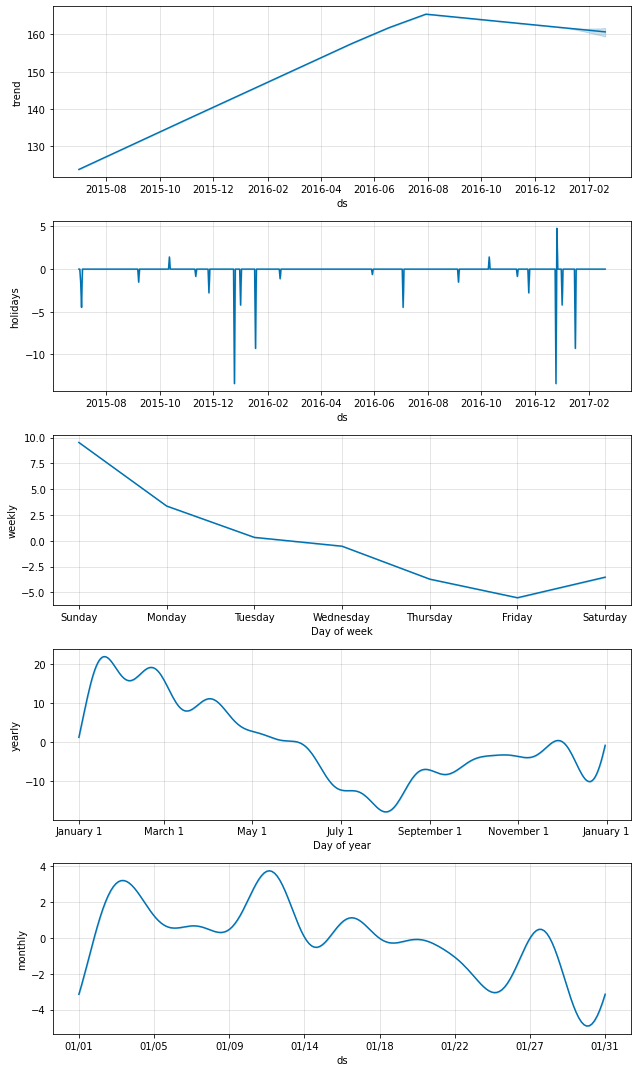

In [148]:
final_model = Prophet(
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 5,
                      n_changepoints = 10,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.add_seasonality(name='monthly', period=30.5, fourier_order=8)

final_model.fit(train_med)
future = final_model.make_future_dataframe(periods=50)
forecast = final_model.predict(future)
fig = final_model.plot_components(forecast)

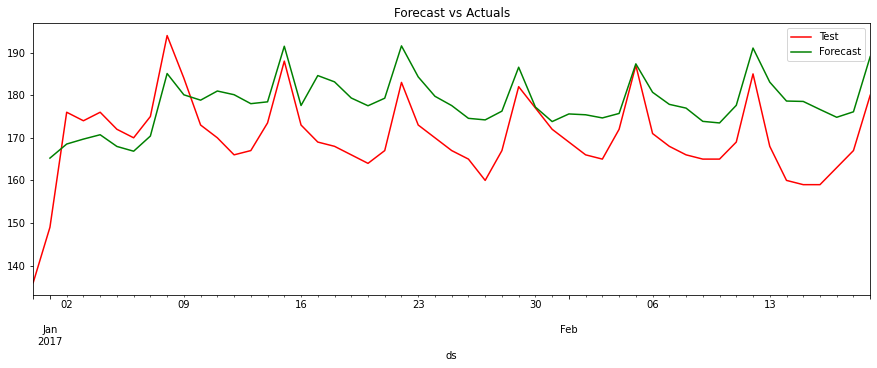

In [149]:
actualVsPredicted(forecast[-50:], test_median[549:600])

In [150]:
print('The errors for Median time series is: ')
mape = mean_absolute_percentage_error(test_median['y'][:600],forecast['yhat'])
print("MAPE",round(mape,4))
print("MAE yhat\t: {}\nMAE trend\t: {}\nMAE yhat_lower: {}\nMAE yhat_upper: {}".format(
    mean_absolute_error(test_median['y'][:600].values, forecast['yhat']),
    mean_absolute_error(test_median['y'][:600].values, forecast['trend']),
    mean_absolute_error(test_median['y'][:600].values, forecast['yhat_lower']),
    mean_absolute_error(test_median['y'][:600].values, forecast['yhat_upper'])))

The errors for Median time series is: 
MAPE 2.6601
MAE yhat	: 3.949649086307044
MAE trend	: 10.007320113523763
MAE yhat_lower: 9.323249169378885
MAE yhat_upper: 10.2714337955785


The errors for Median time series is:

MAPE 2.7531

MAE yhat	: 4.146148786572965

MAE trend	: 37.24553748494217

MAE yhat_lower: 11.04300580286423

MAE yhat_upper: 9.199655872392363